In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
import numpy as np
import cv2
import os

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model, Sequential

Using TensorFlow backend.


In [5]:
# 查看可用的 GPU 
print(K.tensorflow_backend._get_available_gpus())

['/job:localhost/replica:0/task:0/device:GPU:0']


In [6]:
print(os.listdir("/home/cslab/Desktop/3th_ML/Final/Data/image_data/"))

['train', 'valid', 'test']


In [7]:
# 資料路徑
DATASET_PATH  = '/home/cslab/Desktop/3th_ML/Final/Data/image_data/'

# 影像大小
IMAGE_SIZE = (224, 224)

# 影像類別數
NUM_CLASSES = 5

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 8

# 凍結網路層數
FREEZE_LAYERS = 10

# Epoch 數
NUM_EPOCHS = 75

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-resnet50-final-2.h5'

# label class
flower_mapping = {'daisy':0, 'dandelion':1, 'rose':2, 'sunflower':3, 'tulip':4}


flower_mapping_class = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [8]:
# 透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [9]:
train_batches = train_datagen.flow_from_directory(DATASET_PATH + 'train/',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  classes = flower_mapping_class)


Found 2260 images belonging to 5 classes.


In [10]:
# 查看class 數量
len(train_batches.class_indices)

5

In [11]:
valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE,
                                                  classes = flower_mapping_class)


Found 563 images belonging to 5 classes.


In [12]:
# test
# for cls, idx in train_batches.class_indices.items():
#     print('Class #{} = {}'.format(idx, cls))

for cls, idx in flower_mapping.items():
    print('Class #{} = {}'.format(idx, cls))

Class #0 = daisy
Class #1 = dandelion
Class #2 = rose
Class #3 = sunflower
Class #4 = tulip


In [13]:
class_dictionary = train_batches.class_indices 

In [14]:
class_dictionary

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [15]:
# # 接上原本的output
# x = xception_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(output_dim=128, activation='relu')(x)
# x = Dropout(p=0.1)(x)

# # 重新定義輸出類別數量量
# predictions = Dense(output_dim=10,activation='softmax')(x)
# xception_model = Model(inputs=xception_model.input, outputs=predictions)
# print('Model深度：', len(xception_model.layers))

In [16]:
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3), classes=5)

# 接上原本的output
x = net.output

x = Flatten()(x)
# add layer(test)
# x = AveragePooling2D(pool_size=(2,2))(x)

x = BatchNormalization()(x)
# x = Dense(2048, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)


x = Dropout(0.5)(x)

# 重新定義輸出類別數量
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True
    
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

print(net_final.summary())

print('Model深度：', len(net.layers))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [17]:
reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)

In [18]:
# 設定 callback 
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor="val_acc", 
                          patience=10, 
                          verbose=1
                          )

In [19]:
net_final.fit_generator(train_batches,
                        steps_per_epoch = int(train_batches.samples // BATCH_SIZE) + 1,
                        validation_data = valid_batches,
                        validation_steps = int(valid_batches.samples // BATCH_SIZE) + 1,
                        epochs = NUM_EPOCHS,
                        callbacks = [earlystop]
                       )

Epoch 1/75
283/283 [==============================] - 105s 372ms/step - loss: 1.2430 - acc: 0.5914 - val_loss: 0.7252 - val_acc: 0.7744
Epoch 2/75
283/283 [==============================] - 88s 310ms/step - loss: 0.8886 - acc: 0.7133 - val_loss: 0.6742 - val_acc: 0.7940
Epoch 3/75
283/283 [==============================] - 88s 310ms/step - loss: 0.7253 - acc: 0.7597 - val_loss: 0.7084 - val_acc: 0.7975
Epoch 4/75
283/283 [==============================] - 88s 310ms/step - loss: 0.7242 - acc: 0.7822 - val_loss: 0.6603 - val_acc: 0.8064
Epoch 5/75
283/283 [==============================] - 88s 310ms/step - loss: 0.6705 - acc: 0.7836 - val_loss: 0.6938 - val_acc: 0.8064
Epoch 6/75
283/283 [==============================] - 88s 310ms/step - loss: 0.6428 - acc: 0.7937 - val_loss: 0.6473 - val_acc: 0.8348
Epoch 7/75
283/283 [==============================] - 88s 310ms/step - loss: 0.6404 - acc: 0.8163 - val_loss: 0.6376 - val_acc: 0.8313
Epoch 8/75
283/283 [==============================] - 

In [20]:
# net_final.fit_generator(train_batches,
#                         steps_per_epoch = train_batches.samples // BATCH_SIZE,
#                         validation_data = valid_batches,
#                         validation_steps = valid_batches.samples // BATCH_SIZE,
#                         epochs = NUM_EPOCHS
#                        )

In [21]:
net_final.save(WEIGHTS_FINAL)

In [22]:
import matplotlib.pyplot as plt
# 以視覺畫方式檢視訓練過程

train_loss = net_final.history.history["loss"]
valid_loss = net_final.history.history["val_loss"]

train_acc = net_final.history.history["acc"]
valid_acc = net_final.history.history["val_acc"]

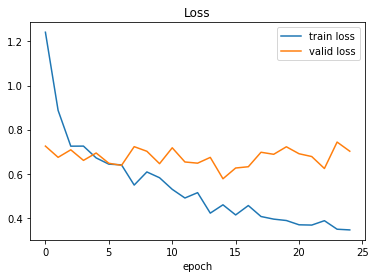

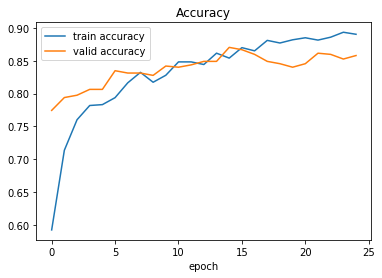

In [23]:
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.xlabel('epoch')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.xlabel('epoch')
plt.legend()
plt.title("Accuracy")
plt.show()

In [24]:
loss, accuracy = net_final.evaluate_generator(valid_batches, train_batches.samples // BATCH_SIZE)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.857207  ;  loss = 0.705116 


#### Prepare Testing Data

In [25]:
import pandas as pd

test_filenames = os.listdir(DATASET_PATH + 'test/')

#### Load model.h5

In [26]:
# 載入訓練好的模型
# net = load_model('model-resnet50-final.h5')

#### Create Testing Generator

In [27]:
# from keras_preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator

In [28]:
# test_gen = ImageDataGenerator(rescale=1./255)
# test_generator = test_gen.flow_from_dataframe(
#     test_df, 
#     DATASET_PATH+ "test/", 
#     x_col='filename',
#     y_col=None,
#     class_mode=None,
#     batch_size=BATCH_SIZE,
#     target_size=IMAGE_SIZE,
#     shuffle=False
# )

In [29]:
# nb_samples = test_df.shape[0]

#### Predict

In [30]:
from tensorflow.python.keras.preprocessing import image
name = []
flower_class = []

for f in test_filenames:
    img = image.load_img(DATASET_PATH +'test/'+ f, target_size=IMAGE_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    pred = net_final.predict(x)[0]
    top_inds = pred.argsort()[::-1][:5]
    name.append(f)
    flower_class.append(top_inds[0])
#     print(f)
#     print(top_inds[0])
    
#     for i in top_inds:
#         print('    {:.3f}  {}'.format(pred[i], flower_mapping_class[i]))

In [31]:
test_df = pd.DataFrame({'id': name, 'flower_class':flower_class})

In [32]:
test_df.head(10)

,id,flower_class
0,00c08828fce04e360c732cac01edad9e.jpg,4
1,64445efce11d32286114cfa6481900f0.jpg,4
2,ecb99d00e461932c0c6bf09975c15a29.jpg,0
3,13b99e66028f1337671c60ce2664d881.jpg,3
4,6c70588c60bd5ba13e633ccc624ec0d4.jpg,4
5,8889d21b83a5eb029dc7521ddbf774f0.jpg,2
6,b9e4e2307b517c419f3f9d5696b33269.jpg,0
7,28b3b0cc87053bbf3893209de3ce3bb0.jpg,1
8,8eccaa06797500c59bc4a00d54718840.jpg,2
9,945a669c81ee08470a52b1e0f994b613.jpg,4


In [33]:
submission_df = test_df.copy()

In [34]:
submission_df.head()

,id,flower_class
0,00c08828fce04e360c732cac01edad9e.jpg,4
1,64445efce11d32286114cfa6481900f0.jpg,4
2,ecb99d00e461932c0c6bf09975c15a29.jpg,0
3,13b99e66028f1337671c60ce2664d881.jpg,3
4,6c70588c60bd5ba13e633ccc624ec0d4.jpg,4


In [35]:
submission_df['id'] = submission_df['id'].str.split('.').str[0]

In [36]:
submission_df

,id,flower_class
0,00c08828fce04e360c732cac01edad9e,4
1,64445efce11d32286114cfa6481900f0,4
2,ecb99d00e461932c0c6bf09975c15a29,0
3,13b99e66028f1337671c60ce2664d881,3
4,6c70588c60bd5ba13e633ccc624ec0d4,4
...,...,...
1995,c98ce3f572993e0ad60bb7a322113060,3
1996,3544d41ec6d741edcd10f11338198db6,0
1997,fda7085f5d8b6f995922b19f5aeec873,1
1998,84bb958662b098a1333cc741ac920402,4


In [37]:
submission_df.sort_values('id',inplace=True)

In [38]:
submission_df.reset_index(drop=True, inplace=True)
submission_df.head(10)

,id,flower_class
0,0028624c49b3e0610ff9f1d111f5d532,2
1,002c30700185b7971369258b438070d5,4
2,00852f4f666acecd0c0d140365b42efd,2
3,00c08828fce04e360c732cac01edad9e,4
4,00d366e7877b6a78b104b57d67b60e6b,4
5,00e803f7bc6d21b6d6d3a98136ea4635,2
6,00e9cb1dca407810856e77b31309d5ab,1
7,014d33090eb706769ff782d8c500dc2a,4
8,015c8f0e6b95baf9dcbb34647624c5b8,2
9,0194948a29f0e891c54f88004fb4c51c,4


In [39]:
submission_df.to_csv('submission.csv', index=False)